# Project: Week 3

This week, I continued my approach from last week.  I wanted to investigate - once COVID-19 got into the US, how did it initially spread?

## Import Stuff

In [1]:
!pip install biopython

In [2]:
import pandas as pd
import numpy as np
import yaml
import urllib
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo
import matplotlib
import random
import matplotlib.pylab as plt
import matplotlib.patches as mpatches

In [3]:
%matplotlib inline

## Get Given Data - aligned sequences

Once again, I started with the data given by my professor.  Below is a table of all of the COVID-19 genomes made available by the galaxy project.  Specifically, this table contains the aligned sequences corresponding to the spike protein.

In [4]:
position_table = pd.read_csv('../../data/position_table.csv')

In [5]:
position_table

,seqid,S_1_1,S_1_2,S_1_3,S_2_1,S_2_2,S_2_3,S_3_1,S_3_2,S_3_3,...,S_1270_3,S_1271_1,S_1271_2,S_1271_3,S_1272_1,S_1272_2,S_1272_3,S_1273_1,S_1273_2,S_1273_3
0,MT007544.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
1,MT019529.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
2,MT019530.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
3,MT019531.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
4,MT019532.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,MT334544.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
673,MT334546.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
674,MT334547.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A
675,MT334557.1,A,T,G,T,T,T,G,T,T,...,A,C,A,T,T,A,C,A,C,A


## Get location and date data

Last time, I wanted to get extra info about these genomes, like when and where the sample was taken.  
After rooting around on the galaxy project website, I found a script called _fetch_sra_acc.sh_.  In this file, I found out that they get their data from the NCBI.  Specifically, they pull info on the genomes from a file called [ncov-sequences.yaml](https://www.ncbi.nlm.nih.gov/core/assets/genbank/files/ncov-sequences.yaml).  I loaded the data into a dictionary to look up in.

In [6]:
with urllib.request.urlopen("https://www.ncbi.nlm.nih.gov/core/assets/genbank/files/ncov-sequences.yaml") as response:
    text = response.read()

In [7]:
lookup = yaml.load(text)

C:\Users\Alex\anaconda3\lib\site-packages\ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [8]:
name_to_description = {}

for description in lookup["genbank-sequences"]:
    name = description["accession"]
    name_to_description[name] = description

## Combine Data

Next, I swept over my genome table to add the extra location and date info.  They changed their format since last time I used the data, so I had to update my code.

In [9]:
position_table["name"] = position_table["seqid"].str.replace("\.\d", "")

In [85]:
def get_location(name):
    if name in name_to_description:
        description = name_to_description[name]
        location = description["country"]
        splits = [fragment.strip() for fragment in location.split(":")]
        country = splits[0]
        state = "".join(splits[1:])
        if state == "":
            state = np.nan
        
        return country, state
    else:
        return np.nan

position_table["country"], position_table["state"] = zip(*position_table["name"].apply(get_location))
position_table["country"].isna().sum(), position_table["state"].isna().sum()

(0, 169)

In [86]:
position_table["country"].unique()

array(['Australia', 'China', 'USA', 'South Korea', 'Taiwan', 'Nepal',
       'Sweden', 'Brazil', 'India', 'Italy', 'Viet Nam', 'Spain',
       'Pakistan', 'Peru', 'Israel', 'France', 'Iran', 'South Africa',
       'Turkey', 'Greece'], dtype=object)

In [87]:
position_table["state"].unique()

array(['Victoria', 'Hubei, Wuhan', 'WA', 'CA', 'Hangzhou', 'WI', 'MA',
       nan, 'IL', 'Yunnan', 'TX', 'Guangdong, Guangzhou', 'Guangzhou',
       'Beijing', 'Snohomish County, WA', 'Kerala State', 'Shanghai',
       'MN', 'CA, San Diego County', 'Ho Chi Minh city', 'Valencia',
       'Gilgit', 'CT', 'Zhejiang, Hangzhou', 'San Francisco, CA', 'KPK',
       'RI', 'GA', 'OR', 'FL', 'Anhui, Fuyang', 'Wuhan', 'North Carolina',
       'AZ', 'NH', 'NY', 'MI', 'NC', 'VA', 'KwaZulu-Natal', 'DC', 'IA',
       'IN', 'KS', 'LA', 'MD', 'MO', 'NE', 'NJ', 'NV', 'OH', 'PA', 'SC',
       'UT'], dtype=object)

Looks like all genomes have a country, but many don't have a state.

In [65]:
def get_date(name):
    if name in name_to_description:
        description = name_to_description[name]
        date = description["collection_date"]
        return date
    else:
        return np.nan

position_table["date"] = position_table["name"].apply(get_date)
position_table["date"].isna().sum()

0

All of the genomes also have a date.  I had to get rid of one malformed date, though.

In [66]:
position_table = position_table[position_table["date"] != "2020"]

In [67]:
position_table["date"] = pd.to_datetime(position_table["date"])

## Problem and Sequence Selection

I wanted to take a look at how COVID-19 started spreading inside the US.  To do this, I selected the first 100 recorded COVID-19 genomes in the US (by date).

In [70]:
position_table = position_table.set_index("seqid")

In [112]:
subset_seqs = position_table[position_table.country == "USA"]["date"].nsmallest(100).index
subset_seqs

Index(['MT233526.1', 'MT246667.1', 'MT020880.1', 'MT020881.1', 'MT044258.1',
       'MT044257.1', 'MT027062.1', 'MT027063.1', 'MT027064.1', 'MT039888.1',
       'MT039887.1', 'MT106052.1', 'MT106053.1', 'MT106054.1', 'MT159705.1',
       'MT159706.1', 'MT159707.1', 'MT159708.1', 'MT159710.1', 'MT159717.1',
       'MT184911.1', 'MT184912.1', 'MT159713.1', 'MT159714.1', 'MT159718.1',
       'MT159719.1', 'MT184907.1', 'MT184910.1', 'MT159709.1', 'MT159711.1',
       'MT159720.1', 'MT159721.1', 'MT159722.1', 'MT184908.1', 'MT184909.1',
       'MT118835.1', 'MT152824.1', 'MT159715.1', 'MT159716.1', 'MT184913.1',
       'MT159712.1', 'MT276324.1', 'MT163716.1', 'MT276325.1', 'MT276328.1',
       'MT163717.1', 'MT276323.1', 'MT276329.1', 'MT276330.1', 'MT163718.1',
       'MT276326.1', 'MT276327.1', 'MT276331.1', 'MT304484.1', 'MT304489.1',
       'MT163719.1', 'MT304482.1', 'MT304483.1', 'MT304487.1', 'MT304488.1',
       'MT304490.1', 'MT304491.1', 'MT322394.1', 'MT322395.1', 'MT322396.1',

## Select our distance metric

Next, I got a distance matrix among all of the selected sequences.  I decided to stick with a simple distance metric - just the number of differences between the two.  This seemed appropriate because the sequences were relatively short and well-aligned.

In [113]:
def get_distance(seq1, seq2):
    return sum(seq1 != seq2)

In [114]:
distances = {}
for i,seqid1 in enumerate(subset_seqs):
    distances[seqid1,seqid1]=0
    for j in range(i+1,len(subset_seqs)):
        seqid2 = subset_seqs[j]
        distances[seqid1,seqid2] = get_distance(position_table.loc[seqid1], position_table.loc[seqid2])
        distances[seqid2,seqid1] = distances[seqid1,seqid2]
distances = pd.Series(distances).unstack()
distances.head()

,MT020880.1,MT020881.1,MT027062.1,MT027063.1,MT027064.1,MT039887.1,MT039888.1,MT044257.1,MT044258.1,MT106052.1,...,MT322419.1,MT322420.1,MT322421.1,MT322422.1,MT322423.1,MT322424.1,MT325565.1,MT325571.1,MT325573.1,MT325574.1
MT020880.1,0,1,3,3,4,3,4,4,3,3,...,4,4,7,7,7,4,4,4,4,3
MT020881.1,1,0,3,3,4,3,4,4,3,3,...,4,4,7,7,7,4,4,4,4,3
MT027062.1,3,3,0,1,2,3,3,4,2,2,...,4,4,7,7,7,4,4,4,4,3
MT027063.1,3,3,1,0,2,3,3,4,2,2,...,4,4,7,7,7,4,4,4,4,3
MT027064.1,4,4,2,2,0,4,4,5,3,3,...,5,5,8,8,8,5,5,5,5,4


In [115]:
position_table.loc[subset_seqs]["state"]

seqid
MT233526.1    WA
MT246667.1    WA
MT020880.1    WA
MT020881.1    WA
MT044258.1    CA
              ..
MT304477.1    AZ
MT304478.1    FL
MT304485.1    NH
MT304486.1    NY
MT325565.1    FL
Name: state, Length: 100, dtype: object

## Select colors for each state

I knew that I would want to visualize my results, so I assigned a color to each of the states in my subset of genomes.

In [116]:
states = position_table.loc[subset_seqs]["state"].unique()
states

array(['WA', 'CA', 'IL', 'MA', 'WI', 'TX', nan, 'Snohomish County, WA',
       'OR', 'RI', 'FL', 'GA', 'NH', 'VA', 'AZ', 'NY'], dtype=object)

In [117]:
state_to_color = {}

In [118]:
all_colors = [color for color in Phylo.BaseTree.BranchColor.color_names
              if len(color) > 1 and color not in ["white", "grey"]]
all_colors

['red',
 'yellow',
 'green',
 'cyan',
 'blue',
 'magenta',
 'black',
 'maroon',
 'olive',
 'lime',
 'aqua',
 'teal',
 'navy',
 'fuchsia',
 'purple',
 'silver',
 'gray',
 'pink',
 'salmon',
 'orange',
 'gold',
 'tan',
 'brown']

In [119]:
#colors = random.sample(all_colors, len(countries))

In [120]:
colors = all_colors[:len(states)]

In [121]:
for state, color in zip(states, colors):
    state_to_color[state] = color

In [122]:
state_to_color

{'WA': 'red',
 'CA': 'yellow',
 'IL': 'green',
 'MA': 'cyan',
 'WI': 'blue',
 'TX': 'magenta',
 nan: 'black',
 'Snohomish County, WA': 'maroon',
 'OR': 'olive',
 'RI': 'lime',
 'FL': 'aqua',
 'GA': 'teal',
 'NH': 'navy',
 'VA': 'fuchsia',
 'AZ': 'purple',
 'NY': 'silver'}

I also made a legend for my graph at the end.

In [123]:
patches = []

for state in state_to_color:
    patch = mpatches.Patch(color=state_to_color[state], label=state)
    patches.append(patch)

## Use Biopython to construct a phylogenetic tree

Finally, I used Biopython to contruct a phylogenetic tree from my distance matrix

In [124]:
matrix = np.tril(distances.values).tolist()
for i in range(len(matrix)):
    matrix[i] = matrix[i][:i+1]
distance_matrix = DistanceMatrix(list(distances.index), matrix)

In [125]:
tree_constructor = DistanceTreeConstructor()

#### Neighbor Joining tree

I tried out a Neighbor Joining tree and an Upgma tree, and the Neighbor Joining tree worked better in the end.

In [126]:
nj_tree = tree_constructor.nj(distance_matrix)

In [127]:
nj_tree.ladderize()

In [128]:
for clade in nj_tree.get_terminals():
    state = get_location(clade.name.split(".")[0])[1]
    clade.color = state_to_color[state]

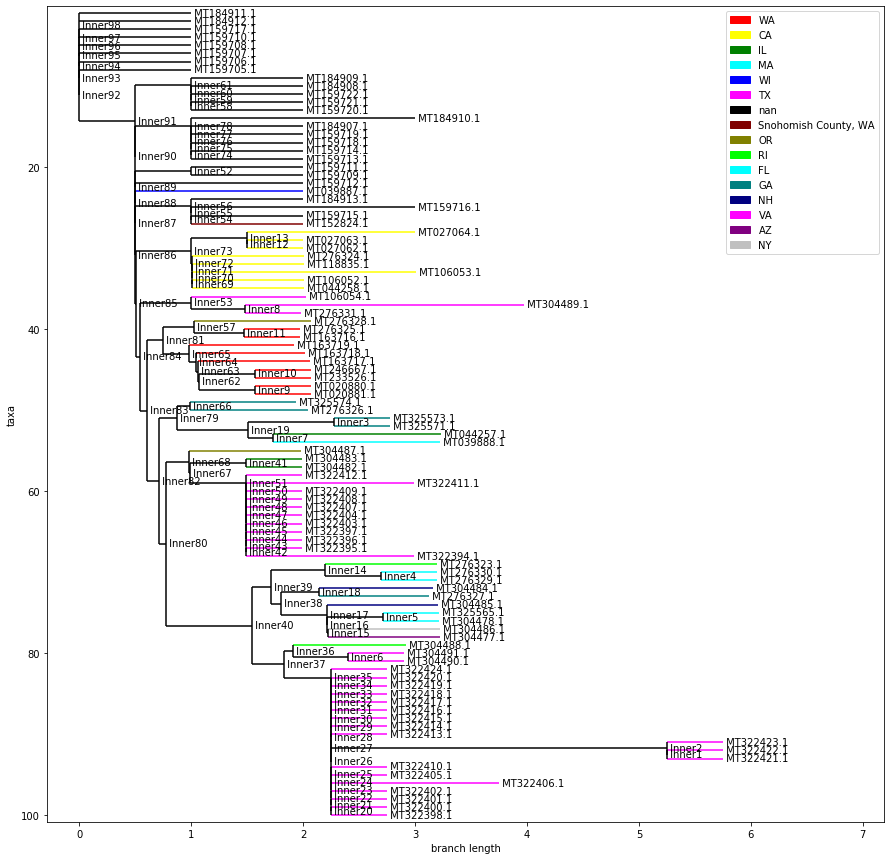

In [129]:
fig = plt.figure(figsize=(15, 15))
axes = fig.add_subplot(1, 1, 1)
plt.legend(handles=patches)
Phylo.draw(nj_tree, axes=axes)

This phylogeny is interesting because of where all of the unknown states show up - they are all clumped together near the top of the tree.  I wonder if they all come from the same place.  The graph also shows many of the genomes with the same color clustered together.  This makes sense, because strains of the virus within a state should be more similar.  This could be some indicator that people are following quarantine/shelter in home guidelines.  However, whenever we see different colors close to each other, it indicates that someone probably traveled to spread the virus from one state to another.  For example, Florida, Rhode Island, New York, New Hampshire, and other states on the east coast seem to be garbled together.  This indicates that many people were probably traveling around to spread the virus.